# Deep Deterministic Policy Gradient (DDPG) and Twin Delayed DDPG (TD3)

## Overview

This notebook implements and compares two state-of-the-art actor-critic algorithms for continuous control:

### DDPG (Deep Deterministic Policy Gradient)
- **Paper**: [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971) (Lillicrap et al., 2015)
- Adapts DQN to continuous action spaces using actor-critic framework
- Uses deterministic policy gradient theorem
- Employs experience replay and target networks for stability

### TD3 (Twin Delayed Deep Deterministic Policy Gradient)
- **Paper**: [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477) (Fujimoto et al., 2018)
- Addresses overestimation bias and instability in DDPG
- **Three key improvements over DDPG**:
  1. **Clipped Double Q-Learning**: Uses two critic networks and takes minimum to reduce overestimation
  2. **Delayed Policy Updates**: Updates policy less frequently than critics to reduce variance
  3. **Target Policy Smoothing**: Adds noise to target actions for robustness

### Environment
- **Reacher-v5**: Fastest training environment (~51 minutes per 1M timesteps)
- Modified timesteps for faster experimentation and convergence analysis

---

**Note**: This notebook is completely self-contained and can run independently without external file dependencies.

## Mathematical Background

### Actor-Critic Framework

Both DDPG and TD3 use the actor-critic paradigm:
- **Actor** $\pi_\phi(s)$: A deterministic policy that maps states to actions
- **Critic** $Q_\theta(s, a)$: A Q-function that estimates the expected return

### Bellman Equation

The Q-function satisfies the Bellman equation:

$$Q^\pi(s, a) = \mathbb{E}_{s' \sim p}[r(s, a) + \gamma Q^\pi(s', \pi(s'))]$$

where:
- $r(s, a)$ is the reward function
- $\gamma$ is the discount factor (typically 0.99)
- $p(s'|s, a)$ is the state transition probability

### DDPG Update Rules

**Critic Update**: Minimize the mean squared Bellman error:

$$L(\theta) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}}[(Q_\theta(s, a) - y)^2]$$

where $y = r + \gamma Q_{\theta'}(s', \pi_{\phi'}(s'))$ and $\theta'$, $\phi'$ are target network parameters.

**Actor Update**: Maximize expected Q-value:

$$\nabla_\phi J(\phi) = \mathbb{E}_{s \sim \mathcal{D}}[\nabla_a Q_\theta(s, a)|_{a=\pi_\phi(s)} \nabla_\phi \pi_\phi(s)]$$

### TD3 Update Rules

**Clipped Double Q-Learning**: TD3 uses **two** critic networks $Q_{\theta_1}$ and $Q_{\theta_2}$:

$$y = r + \gamma \min_{i=1,2} Q_{\theta_i'}(s', \tilde{a}')$$

where $\tilde{a}' = \pi_{\phi'}(s') + \epsilon$ with $\epsilon \sim \text{clip}(\mathcal{N}(0, \sigma), -c, c)$ (target policy smoothing)

**Critic Loss** (for both Q-networks):

$$L(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}}[(Q_{\theta_i}(s, a) - y)^2]$$

**Delayed Actor Update**: Updated every $d$ steps (typically $d=2$):

$$\nabla_\phi J(\phi) = \mathbb{E}_{s \sim \mathcal{D}}[\nabla_a Q_{\theta_1}(s, a)|_{a=\pi_\phi(s)} \nabla_\phi \pi_\phi(s)]$$

### Target Network Updates (Both Algorithms)

Target networks use soft (Polyak) updates:

$$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$
$$\phi' \leftarrow \tau \phi + (1 - \tau) \phi'$$

where $\tau \ll 1$ (typically 0.005)

## Implementation

### Import Dependencies

In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu128


### Replay Buffer

The replay buffer stores past experiences $(s, a, s', r, d)$ and allows random sampling for breaking temporal correlations in the data. This is crucial for off-policy learning stability.

In [2]:
class ReplayBuffer(object):
    """Experience replay buffer for off-policy learning."""
    
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, next_state, reward, done):
        """Add a transition to the buffer."""
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        """Sample a batch of transitions."""
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

print("ReplayBuffer class defined")

ReplayBuffer class defined


### Actor Networks

We define two actor architectures matching the source files:

1. **ActorDDPG** (from DDPG.py): 400-300 architecture
2. **ActorTD3** (from TD3.py): 256-256 architecture

Both use ReLU activations and tanh output scaled by `max_action`.

**DDPG Architecture**: $s \xrightarrow{400} \text{ReLU} \xrightarrow{300} \text{ReLU} \xrightarrow{|A|} \tanh \cdot a_{\text{max}}$

**TD3 Architecture**: $s \xrightarrow{256} \text{ReLU} \xrightarrow{256} \text{ReLU} \xrightarrow{|A|} \tanh \cdot a_{\text{max}}$

In [3]:
class ActorDDPG(nn.Module):
    """Actor network for DDPG (from DDPG.py - 400-300 architecture)."""
    
    def __init__(self, state_dim, action_dim, max_action):
        super(ActorDDPG, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class ActorTD3(nn.Module):
    """Actor network for TD3 (from TD3.py - 256-256 architecture)."""
    
    def __init__(self, state_dim, action_dim, max_action):
        super(ActorTD3, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))

print("Actor network classes defined")

Actor network classes defined


### Critic Networks

We define two critic architectures matching the source files:

1. **CriticDDPG** (from DDPG.py): Processes state through first layer (400), then concatenates with action
2. **CriticTD3** (from TD3.py): Twin critics that concatenate state-action pairs immediately

**DDPG Critic Architecture**:
- $s \xrightarrow{400} \text{ReLU}$
- $[q, a] \xrightarrow{300} \text{ReLU} \xrightarrow{1} Q(s,a)$

**TD3 Critic Architecture** (x2 for twin critics):
- $[s, a] \xrightarrow{256} \text{ReLU} \xrightarrow{256} \text{ReLU} \xrightarrow{1} Q(s,a)$

In [4]:
class CriticDDPG(nn.Module):
    """Critic network for DDPG (from DDPG.py)."""
    
    def __init__(self, state_dim, action_dim):
        super(CriticDDPG, self).__init__()

        # DDPG architecture: state first, then concat with action
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        # Process state first, then concatenate with action
        q = F.relu(self.l1(state))
        q = F.relu(self.l2(torch.cat([q, action], 1)))
        return self.l3(q)


class CriticTD3(nn.Module):
    """Twin critic networks for TD3 (from TD3.py)."""
    
    def __init__(self, state_dim, action_dim):
        super(CriticTD3, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, state, action):
        """Forward pass through both Q-networks."""
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        """Get Q1 value only (used for actor update)."""
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

print("Critic network classes defined")

Critic network classes defined


### DDPG Agent

The DDPG algorithm from DDPG.py (original paper implementation):
- Single critic network with 400-300 architecture
- Actor network with 400-300 architecture
- Direct policy updates every step
- No target policy smoothing
- Learning rate: 1e-4 for actor, weight_decay=1e-2 for critic
- Tau: 0.001 (slower target network updates than TD3)
- Batch size: 64

In [5]:
class DDPG(object):
    """Deep Deterministic Policy Gradient (from DDPG.py - original paper implementation)."""
    
    def __init__(self, state_dim, action_dim, max_action, discount=0.99, tau=0.001):
        # Initialize actor and target actor (using ActorDDPG with 400-300 architecture)
        self.actor = ActorDDPG(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)  # lr=1e-4

        # Initialize critic and target critic
        self.critic = CriticDDPG(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), weight_decay=1e-2)  # weight_decay=1e-2

        self.discount = discount
        self.tau = tau  # tau = 0.001

    def select_action(self, state):
        """Select action using current policy (no exploration noise)."""
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=64):  # batch_size=64 (not 256)
        """Perform one training step."""
        # Sample replay buffer
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # Compute the target Q value
        target_Q = self.critic_target(next_state, self.actor_target(next_state))
        target_Q = reward + (not_done * self.discount * target_Q).detach()

        # Get current Q estimate
        current_Q = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update the frozen target models
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        return critic_loss.item(), actor_loss.item()

    def save(self, filename):
        """Save model parameters."""
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):
        """Load model parameters."""
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)

print("DDPG agent class defined (from DDPG.py)")

DDPG agent class defined (from DDPG.py)


### TD3 Agent

The improved TD3 algorithm from TD3.py implementing three key innovations:
1. **Clipped Double Q-Learning**: Twin critics with 256-256 architecture, uses min of two Q-networks for target
2. **Delayed Policy Updates**: Updates actor every `policy_freq` steps (typically 2)
3. **Target Policy Smoothing**: Adds clipped noise to target actions

Configuration:
- Actor network: 256-256 architecture
- Twin critic networks: 256-256 architecture each
- Learning rate: 3e-4 for both actor and critics
- Tau: 0.005 (faster target network updates than DDPG)
- Batch size: 256

In [6]:
class TD3(object):
    """Twin Delayed Deep Deterministic Policy Gradient (from TD3.py)."""
    
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):
        # Initialize actor and target actor (using ActorTD3 with 256-256 architecture)
        self.actor = ActorTD3(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        # Initialize twin critics and target critics
        self.critic = CriticTD3(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0

    def select_action(self, state):
        """Select action using current policy (no exploration noise)."""
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        """Perform one training step."""
        self.total_it += 1

        # Sample replay buffer
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            # Select action according to policy and add clipped noise (Target Policy Smoothing)
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)
            
            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute target Q value using minimum of two Q-networks (Clipped Double Q-Learning)
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates from both critics
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss (MSE for both Q-networks)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = None
        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor loss (maximize Q1)
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            
            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models using soft (Polyak) updates
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        return critic_loss.item(), actor_loss.item() if actor_loss is not None else None

    def save(self, filename):
        """Save model parameters."""
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):
        """Load model parameters."""
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)

print("TD3 agent class defined (from TD3.py)")

TD3 agent class defined (from TD3.py)


### Evaluation Function

Evaluates the policy over multiple episodes without exploration noise.

In [7]:
def eval_policy(policy, env_name, seed, eval_episodes=10):
    """Evaluate the policy over multiple episodes."""
    eval_env = gym.make(env_name)
    avg_reward = 0.
    for _ in tqdm(range(eval_episodes), desc="Evaluating", leave=False):
        state = eval_env.reset(seed=seed + 100)[0]
        done = False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            avg_reward += reward

    avg_reward /= eval_episodes

    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    return avg_reward

print("Evaluation function defined")

Evaluation function defined


## Training Setup

### Hyperparameters

We use **Reacher-v5** as it's the fastest environment (~51 min/1M steps). We'll reduce timesteps for faster experimentation while maintaining meaningful results.

In [8]:
# Training hyperparameters (matching main.py defaults)
env_name = "Reacher-v5"  # Fastest environment for training
seed = 0

# Training timesteps
max_timesteps = int(1e6)  # 1M timesteps 
start_timesteps = int(25e3)  # 25K initial random exploration (from main.py)
eval_freq = int(5e3)  # Evaluate every 5K steps

batch_size = 256  # Batch size for TD3 (DDPG uses 64, defined in its train method)
discount = 0.99
tau = 0.005  # Default tau for TD3 (DDPG uses 0.001)

# TD3-specific parameters
policy_noise = 0.2
noise_clip = 0.5
policy_freq = 2  # Delayed policy update frequency

expl_noise = 0.1  # Exploration noise std
save_model = True  # Whether to save models

print(f"Environment: {env_name}")
print(f"Seed: {seed}")
print(f"Max timesteps: {max_timesteps:,} 1M")
print(f"Start timesteps: {start_timesteps:,}")
print(f"Evaluation frequency: {eval_freq:,}")
print(f"Batch size: {batch_size} (TD3), 64 (DDPG)")
print(f"\nNote: DDPG uses tau=0.001, TD3 uses tau=0.005")
print(f"Note: DDPG uses batch_size=64, TD3 uses batch_size=256")

Environment: Reacher-v5
Seed: 0
Max timesteps: 1,000,000 1M
Start timesteps: 25,000
Evaluation frequency: 5,000
Batch size: 256 (TD3), 64 (DDPG)

Note: DDPG uses tau=0.001, TD3 uses tau=0.005
Note: DDPG uses batch_size=64, TD3 uses batch_size=256


### Environment Setup

In [9]:
# Create results directory
if not os.path.exists("./notebook_results"):
    os.makedirs("./notebook_results")

if save_model and not os.path.exists("./notebook_models"):
    os.makedirs("./notebook_models")

# Create environment
env = gym.make(env_name)

# Set seeds
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Get environment dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Max action: {max_action}")

State dimension: 10
Action dimension: 2
Max action: 1.0


### Train TD3

## Results Analysis and Comparison

In [10]:
print("="*70)
print("Training DDPG")
print("="*70)

# Initialize DDPG agent with tau=0.001 (from DDPG.py)
ddpg_policy = DDPG(
    state_dim=state_dim,
    action_dim=action_dim,
    max_action=max_action,
    discount=discount,
)

# Initialize replay buffer
ddpg_replay_buffer = ReplayBuffer(state_dim, action_dim)

print("DDPG agent initialized")
print(f"Architecture: 400-300 hidden layers (from DDPG.py)")
print(f"Replay buffer capacity: 1,000,000 transitions")

# Evaluate untrained policy
print("\nEvaluating untrained DDPG policy...")
ddpg_evaluations = [eval_policy(ddpg_policy, env_name, seed)]

# Initialize training variables
state = env.reset(seed=seed + 100)[0]
done = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

ddpg_start_time = time.time()

print(f"\nStarting DDPG training for {max_timesteps:,} timesteps...")
print(f"Random exploration for first {start_timesteps:,} steps")
print(f"Evaluation frequency: every {eval_freq:,} steps\n")

# Main training loop
for t in tqdm(range(int(max_timesteps)), desc="Training DDPG"):
    
    episode_timesteps += 1

    # Select action randomly or according to policy with exploration noise
    if t < start_timesteps:
        action = env.action_space.sample()
    else:
        action = (
            ddpg_policy.select_action(np.array(state))
            + np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action in environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    # Store transition in replay buffer
    ddpg_replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        critic_loss, actor_loss = ddpg_policy.train(ddpg_replay_buffer, batch_size)

    if done:
        # Reset environment
        state = env.reset(seed=seed + 100)[0]
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        eval_reward = eval_policy(ddpg_policy, env_name, seed)
        ddpg_evaluations.append(eval_reward)
        
        if save_model:
            os.makedirs(f"./notebook_models/{env_name}", exist_ok=True)
            ddpg_policy.save(f"./notebook_models/{env_name}/DDPG_seed{seed}")

ddpg_end_time = time.time()
ddpg_duration = ddpg_end_time - ddpg_start_time

print("\nDDPG Training completed!")
hours = int(ddpg_duration // 3600)
minutes = int((ddpg_duration % 3600) // 60)
seconds = int(ddpg_duration % 60)
print(f"Training time: {hours:02d}:{minutes:02d}:{seconds:02d}")
print(f"Final evaluation reward: {ddpg_evaluations[-1]:.3f}")

Training DDPG
DDPG agent initialized
Architecture: 400-300 hidden layers (from DDPG.py)
Replay buffer capacity: 1,000,000 transitions

Evaluating untrained DDPG policy...


Evaluation over 10 episodes: -37.748

Starting DDPG training for 1,000,000 timesteps...
Random exploration for first 25,000 steps
Evaluation frequency: every 5,000 steps



Training DDPG:   1%|          | 5178/1000000 [00:00<02:42, 6132.96it/s] 

Evaluation over 10 episodes: -37.748


Training DDPG:   1%|          | 11604/1000000 [00:01<01:48, 9087.81it/s]

Evaluation over 10 episodes: -37.748


Training DDPG:   2%|▏         | 16743/1000000 [00:01<01:43, 9492.63it/s] 

Evaluation over 10 episodes: -37.748


Training DDPG:   2%|▏         | 21882/1000000 [00:02<01:41, 9592.40it/s] 

Evaluation over 10 episodes: -37.748


Training DDPG:   2%|▏         | 24507/1000000 [00:02<01:27, 11141.98it/s]

Evaluation over 10 episodes: -37.748


Training DDPG:   3%|▎         | 30027/1000000 [00:23<1:13:49, 218.96it/s]

Evaluation over 10 episodes: -1.766


Training DDPG:   4%|▎         | 35041/1000000 [00:40<1:07:29, 238.30it/s]

Evaluation over 10 episodes: -1.123


Training DDPG:   4%|▍         | 40056/1000000 [00:57<1:07:10, 238.19it/s]

Evaluation over 10 episodes: -3.152


Training DDPG:   5%|▍         | 45039/1000000 [01:13<1:07:22, 236.20it/s]

Evaluation over 10 episodes: -3.987


Training DDPG:   5%|▌         | 50028/1000000 [01:30<1:11:54, 220.20it/s]

Evaluation over 10 episodes: -1.336


Training DDPG:   6%|▌         | 55047/1000000 [01:47<1:05:33, 240.21it/s]

Evaluation over 10 episodes: -2.992


Training DDPG:   6%|▌         | 60036/1000000 [02:03<1:05:12, 240.22it/s]

Evaluation over 10 episodes: -3.708


Training DDPG:   7%|▋         | 65057/1000000 [02:20<1:05:04, 239.43it/s]

Evaluation over 10 episodes: -1.654


Training DDPG:   7%|▋         | 70045/1000000 [02:37<1:05:03, 238.24it/s]

Evaluation over 10 episodes: -0.969


Training DDPG:   8%|▊         | 75030/1000000 [02:53<1:04:23, 239.42it/s]

Evaluation over 10 episodes: -0.805


Training DDPG:   8%|▊         | 80050/1000000 [03:10<1:03:54, 239.91it/s]

Evaluation over 10 episodes: -1.068


Training DDPG:   9%|▊         | 85035/1000000 [03:27<1:03:52, 238.75it/s]

Evaluation over 10 episodes: -3.299


Training DDPG:   9%|▉         | 90055/1000000 [03:43<1:03:11, 239.97it/s]

Evaluation over 10 episodes: -2.409


Training DDPG:  10%|▉         | 95044/1000000 [04:00<1:03:14, 238.49it/s]

Evaluation over 10 episodes: -1.530


Training DDPG:  10%|█         | 100031/1000000 [04:17<1:02:30, 239.95it/s]

Evaluation over 10 episodes: -1.295


Training DDPG:  11%|█         | 105053/1000000 [04:33<1:02:06, 240.17it/s]

Evaluation over 10 episodes: -1.355


Training DDPG:  11%|█         | 110040/1000000 [04:50<1:01:56, 239.46it/s]

Evaluation over 10 episodes: -1.726


Training DDPG:  12%|█▏        | 115031/1000000 [05:06<1:01:27, 239.96it/s]

Evaluation over 10 episodes: -2.148


Training DDPG:  12%|█▏        | 120050/1000000 [05:23<1:00:45, 241.35it/s]

Evaluation over 10 episodes: -1.662


Training DDPG:  13%|█▎        | 125041/1000000 [05:40<1:00:28, 241.17it/s]

Evaluation over 10 episodes: -1.362


Training DDPG:  13%|█▎        | 130031/1000000 [05:56<1:00:42, 238.87it/s]

Evaluation over 10 episodes: -1.849


Training DDPG:  14%|█▎        | 135052/1000000 [06:13<1:00:18, 239.04it/s]

Evaluation over 10 episodes: -2.029


Training DDPG:  14%|█▍        | 140042/1000000 [06:30<59:43, 239.94it/s]  

Evaluation over 10 episodes: -2.268


Training DDPG:  15%|█▍        | 145032/1000000 [06:46<59:22, 239.96it/s]  

Evaluation over 10 episodes: -2.051


Training DDPG:  15%|█▌        | 150050/1000000 [07:03<59:34, 237.81it/s]  

Evaluation over 10 episodes: -1.652


Training DDPG:  16%|█▌        | 155038/1000000 [07:20<58:42, 239.85it/s]  

Evaluation over 10 episodes: -0.923


Training DDPG:  16%|█▌        | 160028/1000000 [07:36<1:03:35, 220.14it/s]

Evaluation over 10 episodes: -1.161


Training DDPG:  17%|█▋        | 165047/1000000 [07:53<58:13, 238.98it/s]  

Evaluation over 10 episodes: -0.898


Training DDPG:  17%|█▋        | 170037/1000000 [08:10<57:24, 240.95it/s]  

Evaluation over 10 episodes: -1.128


Training DDPG:  18%|█▊        | 175057/1000000 [08:26<57:20, 239.74it/s]  

Evaluation over 10 episodes: -1.478


Training DDPG:  18%|█▊        | 180046/1000000 [08:43<57:11, 238.92it/s]  

Evaluation over 10 episodes: -1.297


Training DDPG:  19%|█▊        | 185035/1000000 [09:00<56:15, 241.44it/s]  

Evaluation over 10 episodes: -1.342


Training DDPG:  19%|█▉        | 190056/1000000 [09:16<55:33, 242.96it/s]  

Evaluation over 10 episodes: -1.238


Training DDPG:  20%|█▉        | 195047/1000000 [09:33<55:09, 243.24it/s]

Evaluation over 10 episodes: -1.193


Training DDPG:  20%|██        | 200038/1000000 [09:49<54:45, 243.49it/s]

Evaluation over 10 episodes: -1.241


Training DDPG:  21%|██        | 205029/1000000 [10:05<59:03, 224.33it/s]

Evaluation over 10 episodes: -1.434


Training DDPG:  21%|██        | 210051/1000000 [10:22<54:30, 241.51it/s]

Evaluation over 10 episodes: -1.724


Training DDPG:  22%|██▏       | 215042/1000000 [10:38<54:32, 239.85it/s]

Evaluation over 10 episodes: -1.842


Training DDPG:  22%|██▏       | 220033/1000000 [10:55<53:27, 243.15it/s]

Evaluation over 10 episodes: -1.688


Training DDPG:  23%|██▎       | 225055/1000000 [11:11<53:26, 241.68it/s]

Evaluation over 10 episodes: -1.825


Training DDPG:  23%|██▎       | 230045/1000000 [11:28<52:57, 242.35it/s]

Evaluation over 10 episodes: -1.792


Training DDPG:  24%|██▎       | 235036/1000000 [11:44<52:38, 242.23it/s]

Evaluation over 10 episodes: -1.949


Training DDPG:  24%|██▍       | 240058/1000000 [12:01<52:11, 242.65it/s]

Evaluation over 10 episodes: -2.029


Training DDPG:  25%|██▍       | 245049/1000000 [12:17<51:59, 241.98it/s]

Evaluation over 10 episodes: -1.929


Training DDPG:  25%|██▌       | 250040/1000000 [12:34<51:25, 243.06it/s]

Evaluation over 10 episodes: -1.678


Training DDPG:  26%|██▌       | 255031/1000000 [12:50<51:05, 243.00it/s]

Evaluation over 10 episodes: -1.717


Training DDPG:  26%|██▌       | 260053/1000000 [13:07<50:45, 243.00it/s]

Evaluation over 10 episodes: -1.415


Training DDPG:  27%|██▋       | 265044/1000000 [13:23<50:28, 242.68it/s]

Evaluation over 10 episodes: -1.495


Training DDPG:  27%|██▋       | 270035/1000000 [13:40<50:05, 242.84it/s]

Evaluation over 10 episodes: -1.448


Training DDPG:  28%|██▊       | 275057/1000000 [13:56<49:52, 242.29it/s]

Evaluation over 10 episodes: -1.414


Training DDPG:  28%|██▊       | 280047/1000000 [14:13<49:41, 241.47it/s]

Evaluation over 10 episodes: -1.404


Training DDPG:  29%|██▊       | 285038/1000000 [14:29<49:12, 242.16it/s]

Evaluation over 10 episodes: -1.024


Training DDPG:  29%|██▉       | 290029/1000000 [14:46<53:05, 222.88it/s]

Evaluation over 10 episodes: -1.110


Training DDPG:  30%|██▉       | 295051/1000000 [15:02<48:36, 241.71it/s]

Evaluation over 10 episodes: -1.216


Training DDPG:  30%|███       | 300042/1000000 [15:19<47:57, 243.29it/s]

Evaluation over 10 episodes: -1.414


Training DDPG:  31%|███       | 305033/1000000 [15:35<47:43, 242.67it/s]

Evaluation over 10 episodes: -1.893


Training DDPG:  31%|███       | 310055/1000000 [15:52<47:17, 243.14it/s]

Evaluation over 10 episodes: -2.369


Training DDPG:  32%|███▏      | 315046/1000000 [16:08<47:04, 242.52it/s]

Evaluation over 10 episodes: -2.819


Training DDPG:  32%|███▏      | 320037/1000000 [16:25<46:52, 241.73it/s]

Evaluation over 10 episodes: -2.761


Training DDPG:  33%|███▎      | 325028/1000000 [16:41<50:27, 222.96it/s]

Evaluation over 10 episodes: -2.884


Training DDPG:  33%|███▎      | 330050/1000000 [16:58<46:01, 242.63it/s]

Evaluation over 10 episodes: -2.974


Training DDPG:  34%|███▎      | 335041/1000000 [17:14<45:49, 241.82it/s]

Evaluation over 10 episodes: -1.178


Training DDPG:  34%|███▍      | 340032/1000000 [17:31<45:22, 242.38it/s]

Evaluation over 10 episodes: -1.259


Training DDPG:  35%|███▍      | 345054/1000000 [17:47<44:56, 242.93it/s]

Evaluation over 10 episodes: -1.067


Training DDPG:  35%|███▌      | 350045/1000000 [18:04<44:43, 242.20it/s]

Evaluation over 10 episodes: -1.109


Training DDPG:  36%|███▌      | 355036/1000000 [18:20<44:13, 243.07it/s]

Evaluation over 10 episodes: -1.142


Training DDPG:  36%|███▌      | 360058/1000000 [18:37<43:49, 243.37it/s]

Evaluation over 10 episodes: -1.362


Training DDPG:  37%|███▋      | 365047/1000000 [18:53<43:23, 243.92it/s]

Evaluation over 10 episodes: -1.365


Training DDPG:  37%|███▋      | 370038/1000000 [19:10<43:07, 243.48it/s]

Evaluation over 10 episodes: -1.080


Training DDPG:  38%|███▊      | 375029/1000000 [19:26<46:27, 224.22it/s]

Evaluation over 10 episodes: -1.193


Training DDPG:  38%|███▊      | 380051/1000000 [19:42<42:20, 243.99it/s]

Evaluation over 10 episodes: -1.343


Training DDPG:  39%|███▊      | 385045/1000000 [19:59<42:00, 244.02it/s]

Evaluation over 10 episodes: -1.170


Training DDPG:  39%|███▉      | 390043/1000000 [20:15<41:28, 245.11it/s]

Evaluation over 10 episodes: -1.338


Training DDPG:  40%|███▉      | 395037/1000000 [20:31<41:08, 245.03it/s]

Evaluation over 10 episodes: -1.388


Training DDPG:  40%|████      | 400030/1000000 [20:48<44:21, 225.40it/s]

Evaluation over 10 episodes: -1.308


Training DDPG:  41%|████      | 405018/1000000 [21:04<48:14, 205.58it/s]

Evaluation over 10 episodes: -1.352


Training DDPG:  41%|████      | 410041/1000000 [21:20<40:16, 244.19it/s]

Evaluation over 10 episodes: -1.271


Training DDPG:  42%|████▏     | 415048/1000000 [21:37<39:31, 246.70it/s]

Evaluation over 10 episodes: -1.135


Training DDPG:  42%|████▏     | 420052/1000000 [21:53<39:05, 247.26it/s]

Evaluation over 10 episodes: -1.002


Training DDPG:  43%|████▎     | 425029/1000000 [22:09<42:04, 227.79it/s]

Evaluation over 10 episodes: -1.116


Training DDPG:  43%|████▎     | 430050/1000000 [22:25<38:44, 245.20it/s]

Evaluation over 10 episodes: -1.243


Training DDPG:  44%|████▎     | 435035/1000000 [22:42<38:14, 246.27it/s]

Evaluation over 10 episodes: -1.510


Training DDPG:  44%|████▍     | 440048/1000000 [22:58<37:47, 246.92it/s]

Evaluation over 10 episodes: -1.407


Training DDPG:  45%|████▍     | 445055/1000000 [23:14<37:44, 245.06it/s]

Evaluation over 10 episodes: -1.488


Training DDPG:  45%|████▌     | 450042/1000000 [23:31<36:58, 247.92it/s]

Evaluation over 10 episodes: -1.281


Training DDPG:  46%|████▌     | 455034/1000000 [23:47<36:57, 245.80it/s]

Evaluation over 10 episodes: -1.474


Training DDPG:  46%|████▌     | 460056/1000000 [24:03<36:39, 245.54it/s]

Evaluation over 10 episodes: -1.792


Training DDPG:  47%|████▋     | 465028/1000000 [24:19<39:09, 227.73it/s]

Evaluation over 10 episodes: -1.833


Training DDPG:  47%|████▋     | 470040/1000000 [24:36<35:37, 247.90it/s]

Evaluation over 10 episodes: -2.677


Training DDPG:  48%|████▊     | 475029/1000000 [24:52<38:13, 228.90it/s]

Evaluation over 10 episodes: -1.345


Training DDPG:  48%|████▊     | 480038/1000000 [25:08<35:24, 244.74it/s]

Evaluation over 10 episodes: -1.130


Training DDPG:  49%|████▊     | 485038/1000000 [25:24<34:50, 246.37it/s]

Evaluation over 10 episodes: -1.031


Training DDPG:  49%|████▉     | 490030/1000000 [25:41<37:31, 226.53it/s]

Evaluation over 10 episodes: -1.237


Training DDPG:  50%|████▉     | 495043/1000000 [25:57<34:21, 244.96it/s]

Evaluation over 10 episodes: -1.243


Training DDPG:  50%|█████     | 500036/1000000 [26:13<33:42, 247.18it/s]

Evaluation over 10 episodes: -1.722


Training DDPG:  51%|█████     | 505049/1000000 [26:29<33:15, 248.00it/s]

Evaluation over 10 episodes: -1.115


Training DDPG:  51%|█████     | 510041/1000000 [26:46<32:46, 249.17it/s]

Evaluation over 10 episodes: -1.734


Training DDPG:  52%|█████▏    | 515033/1000000 [27:02<32:32, 248.34it/s]

Evaluation over 10 episodes: -2.447


Training DDPG:  52%|█████▏    | 520051/1000000 [27:18<32:22, 247.03it/s]

Evaluation over 10 episodes: -1.816


Training DDPG:  53%|█████▎    | 525040/1000000 [27:34<32:01, 247.19it/s]

Evaluation over 10 episodes: -3.412


Training DDPG:  53%|█████▎    | 530057/1000000 [27:50<31:28, 248.79it/s]

Evaluation over 10 episodes: -3.247


Training DDPG:  54%|█████▎    | 535032/1000000 [28:07<31:24, 246.68it/s]

Evaluation over 10 episodes: -3.885


Training DDPG:  54%|█████▍    | 540052/1000000 [28:23<30:47, 248.98it/s]

Evaluation over 10 episodes: -2.493


Training DDPG:  55%|█████▍    | 545030/1000000 [28:39<33:04, 229.22it/s]

Evaluation over 10 episodes: -2.691


Training DDPG:  55%|█████▌    | 550049/1000000 [28:55<29:52, 251.01it/s]

Evaluation over 10 episodes: -2.762


Training DDPG:  56%|█████▌    | 555040/1000000 [29:11<29:37, 250.38it/s]

Evaluation over 10 episodes: -3.395


Training DDPG:  56%|█████▌    | 560032/1000000 [29:27<29:13, 250.97it/s]

Evaluation over 10 episodes: -3.908


Training DDPG:  57%|█████▋    | 565056/1000000 [29:43<28:56, 250.49it/s]

Evaluation over 10 episodes: -3.930


Training DDPG:  57%|█████▋    | 570047/1000000 [29:59<28:44, 249.27it/s]

Evaluation over 10 episodes: -3.827


Training DDPG:  58%|█████▊    | 575044/1000000 [30:16<28:18, 250.14it/s]

Evaluation over 10 episodes: -3.327


Training DDPG:  58%|█████▊    | 580035/1000000 [30:32<27:54, 250.86it/s]

Evaluation over 10 episodes: -5.382


Training DDPG:  59%|█████▊    | 585059/1000000 [30:48<27:31, 251.19it/s]

Evaluation over 10 episodes: -1.934


Training DDPG:  59%|█████▉    | 590051/1000000 [31:04<27:19, 250.05it/s]

Evaluation over 10 episodes: -3.291


Training DDPG:  60%|█████▉    | 595043/1000000 [31:20<26:51, 251.27it/s]

Evaluation over 10 episodes: -3.105


Training DDPG:  60%|██████    | 600035/1000000 [31:36<26:36, 250.55it/s]

Evaluation over 10 episodes: -3.113


Training DDPG:  61%|██████    | 605059/1000000 [31:52<26:14, 250.88it/s]

Evaluation over 10 episodes: -2.622


Training DDPG:  61%|██████    | 610051/1000000 [32:08<25:49, 251.66it/s]

Evaluation over 10 episodes: -3.326


Training DDPG:  62%|██████▏   | 615043/1000000 [32:24<25:31, 251.39it/s]

Evaluation over 10 episodes: -3.104


Training DDPG:  62%|██████▏   | 620035/1000000 [32:40<25:14, 250.87it/s]

Evaluation over 10 episodes: -3.192


Training DDPG:  63%|██████▎   | 625059/1000000 [32:56<24:44, 252.51it/s]

Evaluation over 10 episodes: -2.695


Training DDPG:  63%|██████▎   | 630051/1000000 [33:12<24:38, 250.17it/s]

Evaluation over 10 episodes: -1.843


Training DDPG:  64%|██████▎   | 635043/1000000 [33:28<24:11, 251.38it/s]

Evaluation over 10 episodes: -1.512


Training DDPG:  64%|██████▍   | 640035/1000000 [33:44<23:54, 250.91it/s]

Evaluation over 10 episodes: -1.018


Training DDPG:  65%|██████▍   | 645059/1000000 [34:00<23:29, 251.86it/s]

Evaluation over 10 episodes: -1.343


Training DDPG:  65%|██████▌   | 650051/1000000 [34:16<23:15, 250.79it/s]

Evaluation over 10 episodes: -1.151


Training DDPG:  66%|██████▌   | 655043/1000000 [34:32<22:58, 250.32it/s]

Evaluation over 10 episodes: -1.425


Training DDPG:  66%|██████▌   | 660035/1000000 [34:48<22:33, 251.23it/s]

Evaluation over 10 episodes: -2.117


Training DDPG:  67%|██████▋   | 665059/1000000 [35:04<22:13, 251.10it/s]

Evaluation over 10 episodes: -1.199


Training DDPG:  67%|██████▋   | 670051/1000000 [35:20<21:55, 250.83it/s]

Evaluation over 10 episodes: -2.774


Training DDPG:  68%|██████▊   | 675043/1000000 [35:36<21:27, 252.30it/s]

Evaluation over 10 episodes: -1.149


Training DDPG:  68%|██████▊   | 680035/1000000 [35:52<21:16, 250.75it/s]

Evaluation over 10 episodes: -1.161


Training DDPG:  69%|██████▊   | 685059/1000000 [36:08<20:49, 252.05it/s]

Evaluation over 10 episodes: -1.154


Training DDPG:  69%|██████▉   | 690051/1000000 [36:24<20:33, 251.19it/s]

Evaluation over 10 episodes: -1.221


Training DDPG:  70%|██████▉   | 695043/1000000 [36:40<20:12, 251.44it/s]

Evaluation over 10 episodes: -1.356


Training DDPG:  70%|███████   | 700035/1000000 [36:56<19:50, 251.87it/s]

Evaluation over 10 episodes: -1.124


Training DDPG:  71%|███████   | 705059/1000000 [37:12<19:33, 251.31it/s]

Evaluation over 10 episodes: -3.064


Training DDPG:  71%|███████   | 710051/1000000 [37:28<19:16, 250.77it/s]

Evaluation over 10 episodes: -3.073


Training DDPG:  72%|███████▏  | 715043/1000000 [37:44<18:58, 250.27it/s]

Evaluation over 10 episodes: -2.898


Training DDPG:  72%|███████▏  | 720034/1000000 [38:00<18:34, 251.24it/s]

Evaluation over 10 episodes: -2.537


Training DDPG:  73%|███████▎  | 725058/1000000 [38:16<18:15, 251.04it/s]

Evaluation over 10 episodes: -1.270


Training DDPG:  73%|███████▎  | 730050/1000000 [38:32<17:57, 250.63it/s]

Evaluation over 10 episodes: -1.102


Training DDPG:  74%|███████▎  | 735041/1000000 [38:48<17:33, 251.44it/s]

Evaluation over 10 episodes: -2.862


Training DDPG:  74%|███████▍  | 740033/1000000 [39:04<17:14, 251.31it/s]

Evaluation over 10 episodes: -2.989


Training DDPG:  75%|███████▍  | 745057/1000000 [39:20<16:53, 251.61it/s]

Evaluation over 10 episodes: -3.002


Training DDPG:  75%|███████▌  | 750049/1000000 [39:36<16:32, 251.82it/s]

Evaluation over 10 episodes: -1.126


Training DDPG:  76%|███████▌  | 755041/1000000 [39:52<16:11, 252.05it/s]

Evaluation over 10 episodes: -2.714


Training DDPG:  76%|███████▌  | 760033/1000000 [40:08<15:53, 251.62it/s]

Evaluation over 10 episodes: -1.119


Training DDPG:  77%|███████▋  | 765056/1000000 [40:24<15:36, 250.84it/s]

Evaluation over 10 episodes: -1.133


Training DDPG:  77%|███████▋  | 770048/1000000 [40:40<15:16, 251.01it/s]

Evaluation over 10 episodes: -2.682


Training DDPG:  78%|███████▊  | 775040/1000000 [40:56<14:54, 251.41it/s]

Evaluation over 10 episodes: -1.298


Training DDPG:  78%|███████▊  | 780031/1000000 [41:13<15:53, 230.63it/s]

Evaluation over 10 episodes: -1.124


Training DDPG:  79%|███████▊  | 785055/1000000 [41:29<14:15, 251.26it/s]

Evaluation over 10 episodes: -2.405


Training DDPG:  79%|███████▉  | 790047/1000000 [41:45<13:59, 250.12it/s]

Evaluation over 10 episodes: -2.499


Training DDPG:  80%|███████▉  | 795039/1000000 [42:01<13:37, 250.83it/s]

Evaluation over 10 episodes: -1.705


Training DDPG:  80%|████████  | 800031/1000000 [42:17<14:23, 231.50it/s]

Evaluation over 10 episodes: -1.933


Training DDPG:  81%|████████  | 805055/1000000 [42:33<12:52, 252.23it/s]

Evaluation over 10 episodes: -2.318


Training DDPG:  81%|████████  | 810047/1000000 [42:49<12:34, 251.70it/s]

Evaluation over 10 episodes: -1.643


Training DDPG:  82%|████████▏ | 815039/1000000 [43:05<12:16, 251.21it/s]

Evaluation over 10 episodes: -2.496


Training DDPG:  82%|████████▏ | 820031/1000000 [43:21<12:54, 232.38it/s]

Evaluation over 10 episodes: -4.426


Training DDPG:  83%|████████▎ | 825055/1000000 [43:37<11:37, 250.80it/s]

Evaluation over 10 episodes: -1.154


Training DDPG:  83%|████████▎ | 830047/1000000 [43:53<11:15, 251.77it/s]

Evaluation over 10 episodes: -2.534


Training DDPG:  84%|████████▎ | 835038/1000000 [44:09<11:11, 245.49it/s]

Evaluation over 10 episodes: -1.336


Training DDPG:  84%|████████▍ | 840030/1000000 [44:25<11:31, 231.32it/s]

Evaluation over 10 episodes: -3.911


Training DDPG:  85%|████████▍ | 845054/1000000 [44:41<10:15, 251.54it/s]

Evaluation over 10 episodes: -1.982


Training DDPG:  85%|████████▌ | 850046/1000000 [44:57<09:58, 250.68it/s]

Evaluation over 10 episodes: -1.285


Training DDPG:  86%|████████▌ | 855038/1000000 [45:13<09:37, 250.80it/s]

Evaluation over 10 episodes: -1.467


Training DDPG:  86%|████████▌ | 860030/1000000 [45:29<10:07, 230.49it/s]

Evaluation over 10 episodes: -2.083


Training DDPG:  87%|████████▋ | 865054/1000000 [45:45<08:55, 251.96it/s]

Evaluation over 10 episodes: -3.293


Training DDPG:  87%|████████▋ | 870046/1000000 [46:01<08:37, 251.30it/s]

Evaluation over 10 episodes: -2.184


Training DDPG:  88%|████████▊ | 875038/1000000 [46:17<08:19, 250.34it/s]

Evaluation over 10 episodes: -2.323


Training DDPG:  88%|████████▊ | 880030/1000000 [46:33<08:35, 232.73it/s]

Evaluation over 10 episodes: -1.525


Training DDPG:  89%|████████▊ | 885054/1000000 [46:49<07:37, 251.48it/s]

Evaluation over 10 episodes: -1.501


Training DDPG:  89%|████████▉ | 890046/1000000 [47:05<07:17, 251.60it/s]

Evaluation over 10 episodes: -1.336


Training DDPG:  90%|████████▉ | 895038/1000000 [47:21<06:56, 251.77it/s]

Evaluation over 10 episodes: -3.076


Training DDPG:  90%|█████████ | 900030/1000000 [47:37<07:11, 231.49it/s]

Evaluation over 10 episodes: -1.441


Training DDPG:  91%|█████████ | 905054/1000000 [47:53<06:17, 251.48it/s]

Evaluation over 10 episodes: -1.343


Training DDPG:  91%|█████████ | 910046/1000000 [48:09<05:56, 252.03it/s]

Evaluation over 10 episodes: -2.704


Training DDPG:  92%|█████████▏| 915038/1000000 [48:25<05:38, 251.10it/s]

Evaluation over 10 episodes: -1.270


Training DDPG:  92%|█████████▏| 920030/1000000 [48:41<05:48, 229.49it/s]

Evaluation over 10 episodes: -1.311


Training DDPG:  93%|█████████▎| 925054/1000000 [48:57<04:58, 251.01it/s]

Evaluation over 10 episodes: -1.400


Training DDPG:  93%|█████████▎| 930046/1000000 [49:13<04:38, 251.54it/s]

Evaluation over 10 episodes: -2.291


Training DDPG:  94%|█████████▎| 935038/1000000 [49:29<04:18, 251.20it/s]

Evaluation over 10 episodes: -1.198


Training DDPG:  94%|█████████▍| 940030/1000000 [49:45<04:19, 231.53it/s]

Evaluation over 10 episodes: -2.078


Training DDPG:  95%|█████████▍| 945054/1000000 [50:01<03:38, 250.93it/s]

Evaluation over 10 episodes: -1.498


Training DDPG:  95%|█████████▌| 950045/1000000 [50:17<03:18, 251.38it/s]

Evaluation over 10 episodes: -1.481


Training DDPG:  96%|█████████▌| 955037/1000000 [50:33<02:59, 250.69it/s]

Evaluation over 10 episodes: -1.749


Training DDPG:  96%|█████████▌| 960029/1000000 [50:49<02:53, 230.78it/s]

Evaluation over 10 episodes: -1.060


Training DDPG:  97%|█████████▋| 965053/1000000 [51:05<02:19, 251.03it/s]

Evaluation over 10 episodes: -1.766


Training DDPG:  97%|█████████▋| 970041/1000000 [51:21<01:59, 250.38it/s]

Evaluation over 10 episodes: -1.584


Training DDPG:  98%|█████████▊| 975033/1000000 [51:37<01:39, 250.43it/s]

Evaluation over 10 episodes: -1.282


Training DDPG:  98%|█████████▊| 980056/1000000 [51:53<01:19, 249.40it/s]

Evaluation over 10 episodes: -1.623


Training DDPG:  99%|█████████▊| 985046/1000000 [52:09<00:59, 250.64it/s]

Evaluation over 10 episodes: -2.368


Training DDPG:  99%|█████████▉| 990036/1000000 [52:25<00:39, 251.57it/s]

Evaluation over 10 episodes: -2.464


Training DDPG: 100%|█████████▉| 995028/1000000 [52:41<00:21, 230.98it/s]

Evaluation over 10 episodes: -2.497


Training DDPG: 100%|██████████| 1000000/1000000 [52:57<00:00, 314.73it/s]

Evaluation over 10 episodes: -2.207

DDPG Training completed!
Training time: 00:52:57
Final evaluation reward: -2.207


In [11]:
print("\n" + "="*70)
print("Training TD3")
print("="*70)

# Initialize TD3 agent
td3_policy = TD3(
    state_dim=state_dim,
    action_dim=action_dim,
    max_action=max_action,
    discount=discount,
    tau=tau,
    policy_noise=policy_noise * max_action,
    noise_clip=noise_clip * max_action,
    policy_freq=policy_freq
)

# Initialize replay buffer
td3_replay_buffer = ReplayBuffer(state_dim, action_dim)

print("TD3 agent initialized")
print(f"Architecture: Twin critics with 256-256 hidden layers")
print(f"Replay buffer capacity: 1,000,000 transitions")

# Evaluate untrained policy
print("\nEvaluating untrained TD3 policy...")
td3_evaluations = [eval_policy(td3_policy, env_name, seed)]

# Initialize training variables
state = env.reset(seed=seed + 100)[0]
done = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

td3_start_time = time.time()

print(f"\nStarting TD3 training for {max_timesteps:,} timesteps...")
print(f"Random exploration for first {start_timesteps:,} steps")
print(f"Evaluation frequency: every {eval_freq:,} steps\n")

# Main training loop
for t in tqdm(range(int(max_timesteps)), desc="Training TD3"):
    
    episode_timesteps += 1

    # Select action randomly or according to policy with exploration noise
    if t < start_timesteps:
        action = env.action_space.sample()
    else:
        action = (
            td3_policy.select_action(np.array(state))
            + np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action in environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    # Store transition in replay buffer
    td3_replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        critic_loss, actor_loss = td3_policy.train(td3_replay_buffer, batch_size)

    if done:
        # Reset environment
        state = env.reset(seed=seed + 100)[0]
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        eval_reward = eval_policy(td3_policy, env_name, seed)
        td3_evaluations.append(eval_reward)
        
        if save_model:
            os.makedirs(f"./notebook_models/{env_name}", exist_ok=True)
            td3_policy.save(f"./notebook_models/{env_name}/TD3_seed{seed}")

td3_end_time = time.time()
td3_duration = td3_end_time - td3_start_time

print("\nTD3 Training completed!")
hours = int(td3_duration // 3600)
minutes = int((td3_duration % 3600) // 60)
seconds = int(td3_duration % 60)
print(f"Training time: {hours:02d}:{minutes:02d}:{seconds:02d}")
print(f"Final evaluation reward: {td3_evaluations[-1]:.3f}")


Training TD3
TD3 agent initialized
Architecture: Twin critics with 256-256 hidden layers
Replay buffer capacity: 1,000,000 transitions

Evaluating untrained TD3 policy...


Evaluation over 10 episodes: -7.070

Starting TD3 training for 1,000,000 timesteps...
Random exploration for first 25,000 steps
Evaluation frequency: every 5,000 steps



Training TD3:   1%|          | 6647/1000000 [00:00<01:38, 10126.89it/s]

Evaluation over 10 episodes: -7.070


Training TD3:   1%|          | 11871/1000000 [00:01<01:39, 9950.65it/s]

Evaluation over 10 episodes: -7.070


Training TD3:   2%|▏         | 17077/1000000 [00:01<01:39, 9910.08it/s] 

Evaluation over 10 episodes: -7.070


Training TD3:   2%|▏         | 22304/1000000 [00:02<01:38, 9939.29it/s] 

Evaluation over 10 episodes: -7.070


Training TD3:   2%|▏         | 24964/1000000 [00:02<01:25, 11424.43it/s]

Evaluation over 10 episodes: -7.070


Training TD3:   3%|▎         | 30048/1000000 [00:18<59:30, 271.64it/s]  

Evaluation over 10 episodes: -1.119


Training TD3:   4%|▎         | 35038/1000000 [00:32<59:10, 271.79it/s]  

Evaluation over 10 episodes: -0.844


Training TD3:   4%|▍         | 40054/1000000 [00:47<59:03, 270.91it/s]  

Evaluation over 10 episodes: -0.802


Training TD3:   5%|▍         | 45058/1000000 [01:02<58:24, 272.47it/s]  

Evaluation over 10 episodes: -1.766


Training TD3:   5%|▌         | 50045/1000000 [01:17<58:09, 272.26it/s]  

Evaluation over 10 episodes: -0.865


Training TD3:   6%|▌         | 55062/1000000 [01:32<57:46, 272.63it/s]  

Evaluation over 10 episodes: -0.905


Training TD3:   6%|▌         | 60048/1000000 [01:46<57:52, 270.65it/s]  

Evaluation over 10 episodes: -0.901


Training TD3:   7%|▋         | 65048/1000000 [02:01<57:13, 272.27it/s]  

Evaluation over 10 episodes: -0.899


Training TD3:   7%|▋         | 70056/1000000 [02:16<57:26, 269.83it/s]  

Evaluation over 10 episodes: -0.895


Training TD3:   8%|▊         | 75046/1000000 [02:31<57:25, 268.47it/s]  

Evaluation over 10 episodes: -0.882


Training TD3:   8%|▊         | 80050/1000000 [02:46<57:03, 268.68it/s]  

Evaluation over 10 episodes: -0.979


Training TD3:   9%|▊         | 85040/1000000 [03:01<56:44, 268.71it/s]  

Evaluation over 10 episodes: -0.968


Training TD3:   9%|▉         | 90041/1000000 [03:15<55:30, 273.23it/s]  

Evaluation over 10 episodes: -0.918


Training TD3:  10%|▉         | 95030/1000000 [03:30<1:00:07, 250.83it/s]

Evaluation over 10 episodes: -0.840


Training TD3:  10%|█         | 100062/1000000 [03:45<55:28, 270.40it/s]  

Evaluation over 10 episodes: -0.866


Training TD3:  11%|█         | 105042/1000000 [04:00<54:50, 272.02it/s]

Evaluation over 10 episodes: -0.808


Training TD3:  11%|█         | 110056/1000000 [04:15<54:55, 270.05it/s]

Evaluation over 10 episodes: -0.788


Training TD3:  12%|█▏        | 115058/1000000 [04:30<54:22, 271.26it/s]

Evaluation over 10 episodes: -0.744


Training TD3:  12%|█▏        | 120045/1000000 [04:44<53:56, 271.90it/s]

Evaluation over 10 episodes: -0.575


Training TD3:  13%|█▎        | 125039/1000000 [04:59<53:34, 272.16it/s]

Evaluation over 10 episodes: -0.594


Training TD3:  13%|█▎        | 130048/1000000 [05:14<53:39, 270.23it/s]

Evaluation over 10 episodes: -0.528


Training TD3:  14%|█▎        | 135064/1000000 [05:29<53:06, 271.48it/s]

Evaluation over 10 episodes: -0.532


Training TD3:  14%|█▍        | 140063/1000000 [05:44<53:34, 267.55it/s]

Evaluation over 10 episodes: -0.568


Training TD3:  15%|█▍        | 145064/1000000 [05:59<52:55, 269.23it/s]

Evaluation over 10 episodes: -0.581


Training TD3:  15%|█▌        | 150032/1000000 [06:14<57:18, 247.16it/s]

Evaluation over 10 episodes: -0.619


Training TD3:  16%|█▌        | 155048/1000000 [06:29<52:15, 269.49it/s]

Evaluation over 10 episodes: -0.544


Training TD3:  16%|█▌        | 160034/1000000 [06:44<51:55, 269.64it/s]

Evaluation over 10 episodes: -0.547


Training TD3:  17%|█▋        | 165042/1000000 [06:58<51:29, 270.28it/s]

Evaluation over 10 episodes: -0.607


Training TD3:  17%|█▋        | 170044/1000000 [07:13<51:08, 270.45it/s]

Evaluation over 10 episodes: -0.579


Training TD3:  18%|█▊        | 175043/1000000 [07:28<50:39, 271.40it/s]

Evaluation over 10 episodes: -0.539


Training TD3:  18%|█▊        | 180032/1000000 [07:43<54:56, 248.75it/s]

Evaluation over 10 episodes: -0.573


Training TD3:  19%|█▊        | 185036/1000000 [07:58<50:16, 270.18it/s]

Evaluation over 10 episodes: -0.524


Training TD3:  19%|█▉        | 190051/1000000 [08:13<49:38, 271.92it/s]

Evaluation over 10 episodes: -0.623


Training TD3:  20%|█▉        | 195062/1000000 [08:28<49:31, 270.87it/s]

Evaluation over 10 episodes: -0.584


Training TD3:  20%|██        | 200061/1000000 [08:42<49:01, 271.94it/s]

Evaluation over 10 episodes: -0.632


Training TD3:  21%|██        | 205054/1000000 [08:57<48:53, 270.98it/s]

Evaluation over 10 episodes: -0.695


Training TD3:  21%|██        | 210063/1000000 [09:12<48:50, 269.52it/s]

Evaluation over 10 episodes: -0.638


Training TD3:  22%|██▏       | 215050/1000000 [09:27<48:08, 271.74it/s]

Evaluation over 10 episodes: -0.755


Training TD3:  22%|██▏       | 220064/1000000 [09:42<47:51, 271.62it/s]

Evaluation over 10 episodes: -0.770


Training TD3:  23%|██▎       | 225048/1000000 [09:57<47:44, 270.55it/s]

Evaluation over 10 episodes: -0.846


Training TD3:  23%|██▎       | 230044/1000000 [10:11<52:52, 242.67it/s]

Evaluation over 10 episodes: -0.767


Training TD3:  23%|██▎       | 234998/1000000 [10:33<37:37, 338.88it/s]  

Evaluation over 10 episodes: -0.806


Training TD3:  24%|██▍       | 240024/1000000 [10:48<58:05, 218.03it/s]  

Evaluation over 10 episodes: -0.783


Training TD3:  25%|██▍       | 245045/1000000 [11:03<46:07, 272.80it/s]

Evaluation over 10 episodes: -0.782


Training TD3:  25%|██▌       | 250024/1000000 [11:18<54:54, 227.63it/s]

Evaluation over 10 episodes: -0.851


Training TD3:  26%|██▌       | 255054/1000000 [11:33<45:53, 270.55it/s]

Evaluation over 10 episodes: -0.805


Training TD3:  26%|██▌       | 260052/1000000 [11:48<45:53, 268.77it/s]

Evaluation over 10 episodes: -0.811


Training TD3:  26%|██▋       | 264972/1000000 [12:03<36:08, 339.00it/s]

Evaluation over 10 episodes: -0.709


Training TD3:  27%|██▋       | 270034/1000000 [12:19<54:22, 223.74it/s]  

Evaluation over 10 episodes: -0.863


Training TD3:  28%|██▊       | 275032/1000000 [12:33<48:45, 247.77it/s]

Evaluation over 10 episodes: -0.871


Training TD3:  28%|██▊       | 280064/1000000 [12:48<44:33, 269.33it/s]

Evaluation over 10 episodes: -0.823


Training TD3:  29%|██▊       | 285062/1000000 [13:03<44:18, 268.97it/s]

Evaluation over 10 episodes: -0.855


Training TD3:  29%|██▉       | 290061/1000000 [13:18<43:51, 269.76it/s]

Evaluation over 10 episodes: -0.806


Training TD3:  30%|██▉       | 295060/1000000 [13:33<43:40, 269.00it/s]

Evaluation over 10 episodes: -0.925


Training TD3:  30%|███       | 300043/1000000 [13:48<42:47, 272.67it/s]

Evaluation over 10 episodes: -0.712


Training TD3:  31%|███       | 305060/1000000 [14:03<43:02, 269.10it/s]

Evaluation over 10 episodes: -0.670


Training TD3:  31%|███       | 310056/1000000 [14:18<42:36, 269.92it/s]

Evaluation over 10 episodes: -0.866


Training TD3:  32%|███▏      | 315060/1000000 [14:33<42:23, 269.24it/s]

Evaluation over 10 episodes: -0.884


Training TD3:  32%|███▏      | 320052/1000000 [14:47<41:34, 272.56it/s]

Evaluation over 10 episodes: -0.889


Training TD3:  33%|███▎      | 325050/1000000 [15:02<41:21, 272.03it/s]

Evaluation over 10 episodes: -0.875


Training TD3:  33%|███▎      | 330049/1000000 [15:17<41:35, 268.42it/s]

Evaluation over 10 episodes: -0.887


Training TD3:  34%|███▎      | 335042/1000000 [15:32<40:59, 270.40it/s]

Evaluation over 10 episodes: -0.854


Training TD3:  34%|███▍      | 340042/1000000 [15:47<40:53, 268.94it/s]

Evaluation over 10 episodes: -0.822


Training TD3:  35%|███▍      | 345058/1000000 [16:02<40:23, 270.28it/s]

Evaluation over 10 episodes: -0.820


Training TD3:  35%|███▌      | 350059/1000000 [16:17<40:07, 269.91it/s]

Evaluation over 10 episodes: -0.904


Training TD3:  36%|███▌      | 355052/1000000 [16:32<39:53, 269.46it/s]

Evaluation over 10 episodes: -0.752


Training TD3:  36%|███▌      | 360036/1000000 [16:46<39:38, 269.05it/s]

Evaluation over 10 episodes: -0.725


Training TD3:  37%|███▋      | 365034/1000000 [17:01<39:14, 269.68it/s]

Evaluation over 10 episodes: -0.720


Training TD3:  37%|███▋      | 370042/1000000 [17:16<39:05, 268.57it/s]

Evaluation over 10 episodes: -0.643


Training TD3:  38%|███▊      | 375032/1000000 [17:31<41:48, 249.13it/s]

Evaluation over 10 episodes: -0.639


Training TD3:  38%|███▊      | 380046/1000000 [17:46<38:24, 269.04it/s]

Evaluation over 10 episodes: -0.610


Training TD3:  39%|███▊      | 385050/1000000 [18:01<37:58, 269.85it/s]

Evaluation over 10 episodes: -0.631


Training TD3:  39%|███▉      | 390048/1000000 [18:16<37:49, 268.81it/s]

Evaluation over 10 episodes: -0.616


Training TD3:  40%|███▉      | 395038/1000000 [18:31<37:19, 270.19it/s]

Evaluation over 10 episodes: -0.624


Training TD3:  40%|████      | 400054/1000000 [18:46<37:07, 269.31it/s]

Evaluation over 10 episodes: -0.619


Training TD3:  41%|████      | 405052/1000000 [19:00<36:50, 269.14it/s]

Evaluation over 10 episodes: -0.624


Training TD3:  41%|████      | 410052/1000000 [19:15<36:34, 268.81it/s]

Evaluation over 10 episodes: -0.700


Training TD3:  42%|████▏     | 415050/1000000 [19:30<36:14, 268.96it/s]

Evaluation over 10 episodes: -0.759


Training TD3:  42%|████▏     | 420048/1000000 [19:45<35:56, 268.98it/s]

Evaluation over 10 episodes: -0.778


Training TD3:  43%|████▎     | 425052/1000000 [20:00<35:32, 269.64it/s]

Evaluation over 10 episodes: -0.794


Training TD3:  43%|████▎     | 430032/1000000 [20:15<38:24, 247.34it/s]

Evaluation over 10 episodes: -0.754


Training TD3:  44%|████▎     | 435030/1000000 [20:30<38:02, 247.49it/s]

Evaluation over 10 episodes: -0.855


Training TD3:  44%|████▍     | 440063/1000000 [20:45<34:37, 269.53it/s]

Evaluation over 10 episodes: -0.890


Training TD3:  45%|████▍     | 445064/1000000 [21:00<34:16, 269.82it/s]

Evaluation over 10 episodes: -0.812


Training TD3:  45%|████▌     | 450063/1000000 [21:15<34:07, 268.54it/s]

Evaluation over 10 episodes: -0.831


Training TD3:  46%|████▌     | 455061/1000000 [21:30<33:45, 269.09it/s]

Evaluation over 10 episodes: -0.723


Training TD3:  46%|████▌     | 460062/1000000 [21:44<33:21, 269.79it/s]

Evaluation over 10 episodes: -0.820


Training TD3:  47%|████▋     | 465060/1000000 [21:59<33:04, 269.57it/s]

Evaluation over 10 episodes: -0.619


Training TD3:  47%|████▋     | 470031/1000000 [22:14<36:20, 243.08it/s]

Evaluation over 10 episodes: -0.779


Training TD3:  48%|████▊     | 475063/1000000 [22:29<32:25, 269.78it/s]

Evaluation over 10 episodes: -0.885


Training TD3:  48%|████▊     | 480062/1000000 [22:44<32:12, 269.07it/s]

Evaluation over 10 episodes: -0.823


Training TD3:  49%|████▊     | 485064/1000000 [22:59<31:49, 269.68it/s]

Evaluation over 10 episodes: -0.717


Training TD3:  49%|████▉     | 490036/1000000 [23:14<31:56, 266.13it/s]

Evaluation over 10 episodes: -0.741


Training TD3:  50%|████▉     | 495034/1000000 [23:29<31:18, 268.86it/s]

Evaluation over 10 episodes: -0.688


Training TD3:  50%|█████     | 500032/1000000 [23:44<33:47, 246.63it/s]

Evaluation over 10 episodes: -0.637


Training TD3:  51%|█████     | 505064/1000000 [23:59<30:37, 269.29it/s]

Evaluation over 10 episodes: -0.798


Training TD3:  51%|█████     | 510062/1000000 [24:14<30:34, 267.05it/s]

Evaluation over 10 episodes: -0.843


Training TD3:  52%|█████▏    | 515060/1000000 [24:29<29:57, 269.80it/s]

Evaluation over 10 episodes: -0.802


Training TD3:  52%|█████▏    | 520058/1000000 [24:43<29:44, 268.93it/s]

Evaluation over 10 episodes: -0.816


Training TD3:  53%|█████▎    | 525056/1000000 [24:58<29:21, 269.66it/s]

Evaluation over 10 episodes: -0.687


Training TD3:  53%|█████▎    | 530056/1000000 [25:13<29:03, 269.58it/s]

Evaluation over 10 episodes: -0.855


Training TD3:  54%|█████▎    | 535054/1000000 [25:28<28:51, 268.48it/s]

Evaluation over 10 episodes: -0.710


Training TD3:  54%|█████▍    | 540052/1000000 [25:43<28:31, 268.69it/s]

Evaluation over 10 episodes: -0.893


Training TD3:  55%|█████▍    | 545050/1000000 [25:58<28:15, 268.35it/s]

Evaluation over 10 episodes: -0.712


Training TD3:  55%|█████▌    | 550050/1000000 [26:13<27:44, 270.40it/s]

Evaluation over 10 episodes: -0.645


Training TD3:  56%|█████▌    | 555048/1000000 [26:28<27:34, 268.87it/s]

Evaluation over 10 episodes: -0.711


Training TD3:  56%|█████▌    | 560046/1000000 [26:43<27:20, 268.15it/s]

Evaluation over 10 episodes: -0.588


Training TD3:  57%|█████▋    | 565044/1000000 [26:58<26:58, 268.81it/s]

Evaluation over 10 episodes: -0.549


Training TD3:  57%|█████▋    | 570042/1000000 [27:13<26:33, 269.86it/s]

Evaluation over 10 episodes: -0.582


Training TD3:  58%|█████▊    | 575040/1000000 [27:28<26:21, 268.71it/s]

Evaluation over 10 episodes: -0.626


Training TD3:  58%|█████▊    | 580038/1000000 [27:43<26:00, 269.18it/s]

Evaluation over 10 episodes: -0.642


Training TD3:  59%|█████▊    | 585036/1000000 [27:57<25:41, 269.28it/s]

Evaluation over 10 episodes: -0.619


Training TD3:  59%|█████▉    | 590034/1000000 [28:12<25:21, 269.45it/s]

Evaluation over 10 episodes: -0.568


Training TD3:  60%|█████▉    | 595032/1000000 [28:27<27:14, 247.78it/s]

Evaluation over 10 episodes: -0.620


Training TD3:  60%|██████    | 600030/1000000 [28:42<26:59, 247.04it/s]

Evaluation over 10 episodes: -0.765


Training TD3:  61%|██████    | 605062/1000000 [28:57<24:29, 268.79it/s]

Evaluation over 10 episodes: -0.583


Training TD3:  61%|██████    | 610060/1000000 [29:12<24:04, 269.91it/s]

Evaluation over 10 episodes: -0.569


Training TD3:  62%|██████▏   | 615058/1000000 [29:27<23:52, 268.76it/s]

Evaluation over 10 episodes: -0.584


Training TD3:  62%|██████▏   | 620056/1000000 [29:42<23:34, 268.58it/s]

Evaluation over 10 episodes: -0.571


Training TD3:  63%|██████▎   | 625056/1000000 [29:57<23:13, 269.09it/s]

Evaluation over 10 episodes: -0.615


Training TD3:  63%|██████▎   | 630054/1000000 [30:12<22:53, 269.41it/s]

Evaluation over 10 episodes: -0.574


Training TD3:  64%|██████▎   | 635052/1000000 [30:27<22:32, 269.90it/s]

Evaluation over 10 episodes: -0.615


Training TD3:  64%|██████▍   | 640050/1000000 [30:42<22:16, 269.40it/s]

Evaluation over 10 episodes: -0.554


Training TD3:  65%|██████▍   | 645048/1000000 [30:57<22:00, 268.72it/s]

Evaluation over 10 episodes: -0.608


Training TD3:  65%|██████▌   | 650046/1000000 [31:12<21:37, 269.77it/s]

Evaluation over 10 episodes: -0.544


Training TD3:  66%|██████▌   | 655044/1000000 [31:27<21:24, 268.47it/s]

Evaluation over 10 episodes: -0.585


Training TD3:  66%|██████▌   | 660042/1000000 [31:41<21:03, 269.08it/s]

Evaluation over 10 episodes: -0.583


Training TD3:  67%|██████▋   | 665040/1000000 [31:56<20:50, 267.93it/s]

Evaluation over 10 episodes: -0.621


Training TD3:  67%|██████▋   | 670038/1000000 [32:11<20:27, 268.90it/s]

Evaluation over 10 episodes: -0.634


Training TD3:  68%|██████▊   | 675035/1000000 [32:26<20:12, 268.10it/s]

Evaluation over 10 episodes: -0.609


Training TD3:  68%|██████▊   | 680033/1000000 [32:41<21:39, 246.18it/s]

Evaluation over 10 episodes: -0.584


Training TD3:  69%|██████▊   | 685031/1000000 [32:56<21:17, 246.61it/s]

Evaluation over 10 episodes: -0.622


Training TD3:  69%|██████▉   | 690063/1000000 [33:11<19:14, 268.44it/s]

Evaluation over 10 episodes: -0.581


Training TD3:  70%|██████▉   | 695061/1000000 [33:26<18:58, 267.88it/s]

Evaluation over 10 episodes: -0.553


Training TD3:  70%|███████   | 700059/1000000 [33:41<18:38, 268.07it/s]

Evaluation over 10 episodes: -0.550


Training TD3:  71%|███████   | 705057/1000000 [33:56<18:21, 267.71it/s]

Evaluation over 10 episodes: -0.592


Training TD3:  71%|███████   | 710055/1000000 [34:11<17:58, 268.95it/s]

Evaluation over 10 episodes: -0.552


Training TD3:  72%|███████▏  | 715053/1000000 [34:26<17:43, 267.95it/s]

Evaluation over 10 episodes: -0.548


Training TD3:  72%|███████▏  | 720051/1000000 [34:41<17:24, 268.11it/s]

Evaluation over 10 episodes: -0.563


Training TD3:  73%|███████▎  | 725058/1000000 [34:56<16:58, 270.05it/s]

Evaluation over 10 episodes: -0.581


Training TD3:  73%|███████▎  | 730060/1000000 [35:11<16:41, 269.57it/s]

Evaluation over 10 episodes: -0.570


Training TD3:  74%|███████▎  | 735058/1000000 [35:26<16:27, 268.39it/s]

Evaluation over 10 episodes: -0.575


Training TD3:  74%|███████▍  | 740056/1000000 [35:41<16:07, 268.76it/s]

Evaluation over 10 episodes: -0.599


Training TD3:  75%|███████▍  | 745054/1000000 [35:56<15:51, 268.04it/s]

Evaluation over 10 episodes: -0.621


Training TD3:  75%|███████▌  | 750052/1000000 [36:11<15:30, 268.58it/s]

Evaluation over 10 episodes: -0.565


Training TD3:  76%|███████▌  | 755050/1000000 [36:26<15:11, 268.84it/s]

Evaluation over 10 episodes: -0.589


Training TD3:  76%|███████▌  | 760048/1000000 [36:41<14:54, 268.36it/s]

Evaluation over 10 episodes: -0.584


Training TD3:  77%|███████▋  | 765046/1000000 [36:55<14:35, 268.24it/s]

Evaluation over 10 episodes: -0.598


Training TD3:  77%|███████▋  | 770044/1000000 [37:10<14:15, 268.80it/s]

Evaluation over 10 episodes: -0.622


Training TD3:  78%|███████▊  | 775042/1000000 [37:25<13:59, 268.04it/s]

Evaluation over 10 episodes: -0.562


Training TD3:  78%|███████▊  | 780044/1000000 [37:40<13:35, 269.62it/s]

Evaluation over 10 episodes: -0.603


Training TD3:  79%|███████▊  | 785042/1000000 [37:55<13:19, 268.78it/s]

Evaluation over 10 episodes: -0.550


Training TD3:  79%|███████▉  | 790040/1000000 [38:10<13:00, 268.99it/s]

Evaluation over 10 episodes: -0.540


Training TD3:  80%|███████▉  | 795038/1000000 [38:25<12:42, 268.92it/s]

Evaluation over 10 episodes: -0.567


Training TD3:  80%|████████  | 800036/1000000 [38:40<12:25, 268.12it/s]

Evaluation over 10 episodes: -0.559


Training TD3:  81%|████████  | 805034/1000000 [38:55<12:07, 267.83it/s]

Evaluation over 10 episodes: -0.508


Training TD3:  81%|████████  | 810032/1000000 [39:10<12:46, 247.71it/s]

Evaluation over 10 episodes: -0.532


Training TD3:  82%|████████▏ | 815064/1000000 [39:25<11:27, 268.87it/s]

Evaluation over 10 episodes: -0.529


Training TD3:  82%|████████▏ | 820062/1000000 [39:40<11:09, 268.58it/s]

Evaluation over 10 episodes: -0.526


Training TD3:  83%|████████▎ | 825060/1000000 [39:55<10:50, 269.09it/s]

Evaluation over 10 episodes: -0.566


Training TD3:  83%|████████▎ | 830062/1000000 [40:09<10:28, 270.18it/s]

Evaluation over 10 episodes: -0.554


Training TD3:  84%|████████▎ | 835062/1000000 [40:24<10:12, 269.43it/s]

Evaluation over 10 episodes: -0.522


Training TD3:  84%|████████▍ | 840060/1000000 [40:39<09:54, 268.82it/s]

Evaluation over 10 episodes: -0.544


Training TD3:  85%|████████▍ | 845058/1000000 [40:54<09:37, 268.37it/s]

Evaluation over 10 episodes: -0.587


Training TD3:  85%|████████▌ | 850056/1000000 [41:09<09:17, 269.15it/s]

Evaluation over 10 episodes: -0.528


Training TD3:  86%|████████▌ | 855054/1000000 [41:24<08:57, 269.47it/s]

Evaluation over 10 episodes: -0.528


Training TD3:  86%|████████▌ | 860052/1000000 [41:39<08:38, 269.73it/s]

Evaluation over 10 episodes: -0.631


Training TD3:  87%|████████▋ | 865052/1000000 [41:54<08:20, 269.50it/s]

Evaluation over 10 episodes: -0.554


Training TD3:  87%|████████▋ | 870050/1000000 [42:09<08:07, 266.38it/s]

Evaluation over 10 episodes: -0.602


Training TD3:  88%|████████▊ | 875044/1000000 [42:24<08:02, 259.04it/s]

Evaluation over 10 episodes: -0.555


Training TD3:  88%|████████▊ | 880033/1000000 [42:39<08:05, 247.03it/s]

Evaluation over 10 episodes: -0.532


Training TD3:  89%|████████▊ | 885031/1000000 [42:54<07:45, 247.17it/s]

Evaluation over 10 episodes: -0.489


Training TD3:  89%|████████▉ | 890063/1000000 [43:09<06:51, 267.01it/s]

Evaluation over 10 episodes: -0.498


Training TD3:  90%|████████▉ | 895061/1000000 [43:24<06:30, 268.86it/s]

Evaluation over 10 episodes: -0.548


Training TD3:  90%|█████████ | 900059/1000000 [43:39<06:11, 269.09it/s]

Evaluation over 10 episodes: -0.565


Training TD3:  91%|█████████ | 905057/1000000 [43:54<05:52, 269.16it/s]

Evaluation over 10 episodes: -0.593


Training TD3:  91%|█████████ | 910055/1000000 [44:08<05:34, 269.05it/s]

Evaluation over 10 episodes: -0.582


Training TD3:  92%|█████████▏| 915034/1000000 [44:23<05:14, 269.83it/s]

Evaluation over 10 episodes: -0.587


Training TD3:  92%|█████████▏| 920032/1000000 [44:38<05:23, 247.49it/s]

Evaluation over 10 episodes: -0.595


Training TD3:  93%|█████████▎| 925030/1000000 [44:53<05:03, 246.79it/s]

Evaluation over 10 episodes: -0.552


Training TD3:  93%|█████████▎| 930062/1000000 [45:08<04:20, 268.81it/s]

Evaluation over 10 episodes: -0.600


Training TD3:  94%|█████████▎| 935060/1000000 [45:23<04:01, 269.09it/s]

Evaluation over 10 episodes: -0.527


Training TD3:  94%|█████████▍| 940058/1000000 [45:38<03:43, 268.50it/s]

Evaluation over 10 episodes: -0.561


Training TD3:  95%|█████████▍| 945056/1000000 [45:53<03:24, 268.59it/s]

Evaluation over 10 episodes: -0.583


Training TD3:  95%|█████████▌| 950054/1000000 [46:08<03:05, 269.61it/s]

Evaluation over 10 episodes: -0.538


Training TD3:  96%|█████████▌| 955052/1000000 [46:23<02:47, 268.45it/s]

Evaluation over 10 episodes: -0.535


Training TD3:  96%|█████████▌| 960050/1000000 [46:38<02:28, 269.12it/s]

Evaluation over 10 episodes: -0.550


Training TD3:  97%|█████████▋| 965048/1000000 [46:53<02:09, 269.37it/s]

Evaluation over 10 episodes: -0.567


Training TD3:  97%|█████████▋| 970046/1000000 [47:08<01:51, 267.99it/s]

Evaluation over 10 episodes: -0.588


Training TD3:  98%|█████████▊| 975058/1000000 [47:22<01:32, 268.48it/s]

Evaluation over 10 episodes: -0.521


Training TD3:  98%|█████████▊| 980056/1000000 [47:37<01:14, 268.25it/s]

Evaluation over 10 episodes: -0.550


Training TD3:  99%|█████████▊| 985054/1000000 [47:52<00:55, 268.71it/s]

Evaluation over 10 episodes: -0.533


Training TD3:  99%|█████████▉| 990052/1000000 [48:07<00:36, 269.08it/s]

Evaluation over 10 episodes: -0.518


Training TD3: 100%|█████████▉| 995050/1000000 [48:22<00:18, 268.89it/s]

Evaluation over 10 episodes: -0.625


Training TD3: 100%|██████████| 1000000/1000000 [48:37<00:00, 342.77it/s]

Evaluation over 10 episodes: -0.575

TD3 Training completed!
Training time: 00:48:37
Final evaluation reward: -0.575


### Save Results

In [12]:
# Save evaluation results
os.makedirs(f"./notebook_results/{env_name}", exist_ok=True)

np.save(f"./notebook_results/{env_name}/DDPG_seed{seed}.npy", ddpg_evaluations)
np.save(f"./notebook_results/{env_name}/TD3_seed{seed}.npy", td3_evaluations)

print(f"Results saved to ./notebook_results/{env_name}/")
print(f"\nDDPG Final evaluation reward: {ddpg_evaluations[-1]:.3f}")
print(f"TD3 Final evaluation reward: {td3_evaluations[-1]:.3f}")
print(f"\nImprovement: {((td3_evaluations[-1] - ddpg_evaluations[-1]) / abs(ddpg_evaluations[-1]) * 100):.1f}%")

Results saved to ./notebook_results/Reacher-v5/

DDPG Final evaluation reward: -2.207
TD3 Final evaluation reward: -0.575

Improvement: 73.9%


### Comparative Visualization

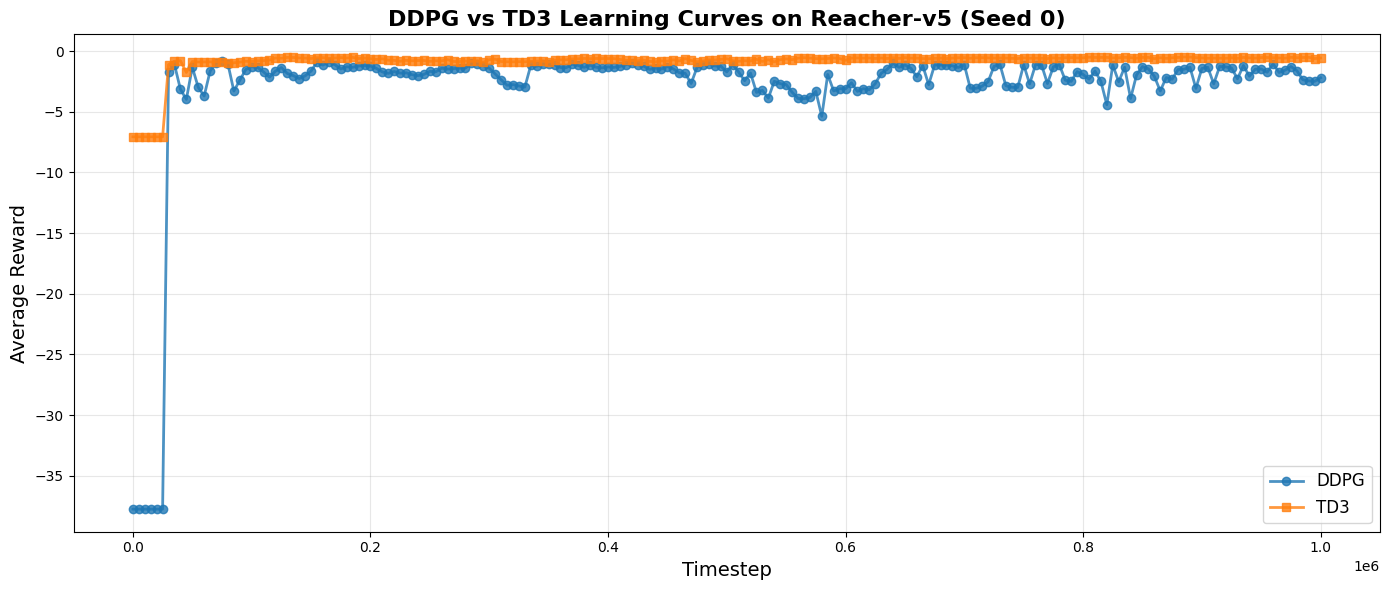


Comparative learning curve saved to ./notebook_results/Reacher-v5/comparison_seed0.png


In [13]:
# Plot comparative learning curves
timesteps = np.array([i * eval_freq if i > 0 else 0 for i in range(len(ddpg_evaluations))])

plt.figure(figsize=(14, 6))

# Plot both algorithms
plt.plot(timesteps, ddpg_evaluations, marker='o', linewidth=2, label='DDPG', alpha=0.8)
plt.plot(timesteps, td3_evaluations, marker='s', linewidth=2, label='TD3', alpha=0.8)

plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.title(f'DDPG vs TD3 Learning Curves on {env_name} (Seed {seed})', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'./notebook_results/{env_name}/comparison_seed{seed}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparative learning curve saved to ./notebook_results/{env_name}/comparison_seed{seed}.png")

### Performance Summary Table

In [14]:
# Create summary table
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(f"Environment: {env_name}")
print(f"Seed: {seed}")
print(f"Total timesteps: {max_timesteps:,}")
print("\n" + "-"*70)
print(f"{'Algorithm':<15} {'Final Reward':<15} {'Training Time':<20}")
print("-"*70)

ddpg_h = int(ddpg_duration // 3600)
ddpg_m = int((ddpg_duration % 3600) // 60)
ddpg_s = int(ddpg_duration % 60)

td3_h = int(td3_duration // 3600)
td3_m = int((td3_duration % 3600) // 60)
td3_s = int(td3_duration % 60)

print(f"{'DDPG':<15} {ddpg_evaluations[-1]:<15.3f} {ddpg_h:02d}:{ddpg_m:02d}:{ddpg_s:02d}")
print(f"{'TD3':<15} {td3_evaluations[-1]:<15.3f} {td3_h:02d}:{td3_m:02d}:{td3_s:02d}")
print("-"*70)

improvement = ((td3_evaluations[-1] - ddpg_evaluations[-1]) / abs(ddpg_evaluations[-1]) * 100)
print(f"\nTD3 Improvement over DDPG: {improvement:+.1f}%")
print("="*70)


PERFORMANCE SUMMARY
Environment: Reacher-v5
Seed: 0
Total timesteps: 1,000,000

----------------------------------------------------------------------
Algorithm       Final Reward    Training Time       
----------------------------------------------------------------------
DDPG            -2.207          00:52:57
TD3             -0.575          00:48:37
----------------------------------------------------------------------

TD3 Improvement over DDPG: +73.9%


## Key Insights and Analysis

### DDPG vs TD3: Key Differences

| Feature | DDPG (from DDPG.py) | TD3 (from TD3.py) |
|---------|---------------------|-------------------|
| **Actor Architecture** | 400-300 | 256-256 |
| **Critic Architecture** | Single: s→400, [h,a]→300→1 | Twin: [s,a]→256→256→1 (x2) |
| **Actor LR** | 1e-4 | 3e-4 |
| **Critic Optimizer** | weight_decay=1e-2 | lr=3e-4 |
| **Tau** | 0.001 | 0.005 |
| **Batch Size** | 64 | 256 |
| **Policy Updates** | Every step | Delayed (every 2 steps) |
| **Target Smoothing** | None | Clipped noise on target actions |
| **Overestimation Bias** | Prone to overestimation | Reduced via min of two Q-values |

### Why TD3 Typically Outperforms DDPG

1. **Clipped Double Q-Learning**: Taking the minimum of two Q-estimates reduces overestimation bias that plagues DDPG
2. **Delayed Policy Updates**: Waiting for the value function to converge before updating the policy reduces variance
3. **Target Policy Smoothing**: Adding noise to target actions smooths the value estimate and prevents overfitting to narrow peaks

### Environment-Specific Observations

**Reacher-v5** characteristics:
- State space: 10 dimensions (joint angles and velocities, target position)
- Action space: 2 dimensions (continuous torques)
- Episode length: 50 steps
- Goal: Move robot arm to reach target position
- Reward: Negative distance to target (higher is better, max ~0)

### Architecture Details

**DDPG Architecture:**
```
Actor:  state_dim -> 400 -> 300 -> action_dim
Critic: state_dim -> 400, then [hidden_400, action_dim] -> 300 -> 1
```

**TD3 Architecture:**
```
Actor:   state_dim -> 256 -> 256 -> action_dim
Critic1: [state_dim, action_dim] -> 256 -> 256 -> 1
Critic2: [state_dim, action_dim] -> 256 -> 256 -> 1
```

## Summary

This notebook implemented and compared two state-of-the-art continuous control algorithms using their exact implementations from source files:

### DDPG (Deep Deterministic Policy Gradient) from DDPG.py
- **Key Components**:
  - Deterministic actor-critic framework
  - Single Q-function for value estimation (400-300 architecture, state processed first)
  - Actor network: 400-300 architecture
  - Target networks with soft updates (τ = 0.001)
  - Experience replay for off-policy learning
  - Updates policy every step
  - Learning rates: actor 1e-4, critic weight_decay=1e-2
  - Batch size: 64

### TD3 (Twin Delayed Deep Deterministic Policy Gradient) from TD3.py
- **Key Components**:
  - **Clipped Double Q-Learning**: Two Q-functions (256-256 each), use minimum for targets
  - **Delayed Policy Updates**: Actor updated every 2 steps
  - **Target Policy Smoothing**: Noise added to target actions
  - Actor network: 256-256 architecture
  - Experience replay and target networks (τ = 0.005)
  - Learning rate: 3e-4 for both actor and critics
  - Batch size: 256

### Comparison Visualization

Results are visualized using matplotlib for learning curves and performance comparisons between DDPG and TD3. The comparison script from `compare_td3_ddpg.py` can be used to generate detailed statistical comparisons across multiple seeds and environments.

### References
1. [DDPG Paper](https://arxiv.org/abs/1509.02971) - Lillicrap et al., 2015
2. [TD3 Paper](https://arxiv.org/abs/1802.09477) - Fujimoto et al., 2018
3. [TD3 Official Implementation](https://github.com/sfujim/TD3)
4. [OpenAI Spinning Up in Deep RL](https://spinningup.openai.com/)